# Creating the Dataset

In [1]:
import cv2
import numpy as np

background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350


def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)


def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [14]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = 'A'
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    # filpping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            #cv2.imshow("Sign Detection",frame_copy)
         
    #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
        # Checking if hand is actually detected by counting number of contours detected...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            #cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            #cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 300:
                #cv2.imwrite(r"D:\\gesture\\train\\"+str(element)+"\\" + str(num_imgs_taken+300) + '.jpg', thresholded)
                cv2.imwrite("dataset/train/" + str(element) + "/" + str(num_imgs_taken) + '.jpg', thresholded)
            elif num_imgs_taken > 300 and num_imgs_taken <= 400:
                cv2.imwrite("dataset/test/" + str(element) + "/" + str(num_imgs_taken) + '.jpg', thresholded)
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "Hand Sign Recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Releasing camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

# Training the model

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import itertools
import random
import warnings
import numpy as np
import cv2

import matplotlib.pyplot as plt

# warnings.simplefilter(action='ignore', category=FutureWarning)


# train_path = 'dataset/train'
# test_path = 'dataset/test'

# train_batches = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, 
#                                                                                              target_size=(64,64),
#                                                                                              class_mode='categorical', 
#                                                                                              batch_size=10,shuffle=True)
# test_batches = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, 
#                                                                                              target_size=(64,64), 
#                                                                                              class_mode='categorical', 
#                                                                                              batch_size=10, shuffle=True)

# imgs, labels = next(train_batches)


# #Plotting the images...
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 10, figsize=(30,20))
#     axes = axes.flatten()
#     for img, ax in zip( images_arr, axes):
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()




c:\users\goelm\anaconda3\envs\cv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\goelm\anaconda3\envs\cv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\goelm\anaconda3\envs\cv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\goelm\anaconda3\envs\cv\lib\site-packages\tensorflow\python\framework\dty

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

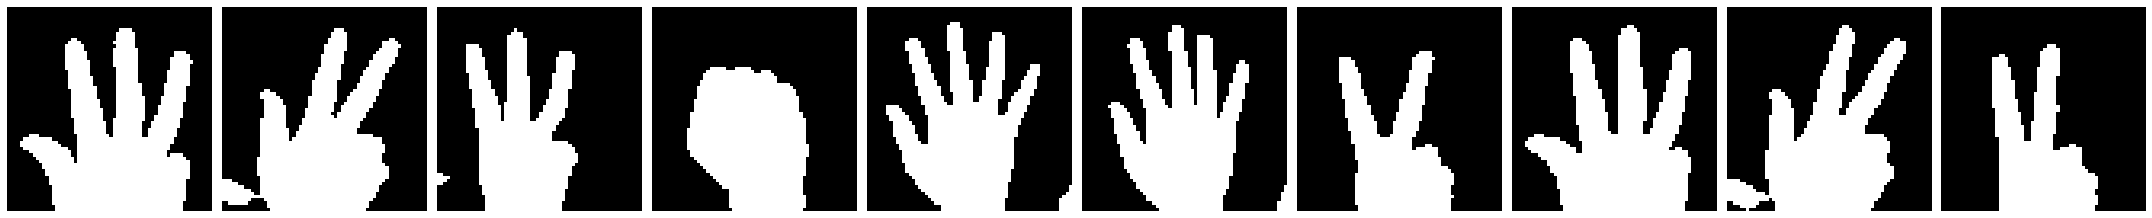

(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [2]:
plotImages(imgs)
print(imgs.shape)
print(labels)



In [17]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'))
# model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
# model.add(Dense(128,activation ="relu"))
# model.add(Dropout(0.5))
# # model.add(Dense(256,activation ="relu"))
# # model.add(Dropout(0.5))
model.add(Dense(10,activation ="softmax"))

print(model.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 31, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                460864    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
__________

In [18]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("sign_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1, min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

nb_train_samples = 3010
nb_validation_samples = 1000
batch_size=8

history2 = model.fit_generator(train_batches, epochs=50,
                               callbacks=[reduce_lr, earlystop],
                               steps_per_epoch = nb_train_samples // batch_size,
                               validation_data = test_batches,
                               validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
376/376 [==============================] - 23s 62ms/step - loss: 14.3687 - acc: 0.1080 - val_loss: 12.9074 - val_acc: 0.1992
Epoch 2/50
376/376 [==============================] - 19s 49ms/step - loss: 14.4449 - acc: 0.1035 - val_loss: 14.5192 - val_acc: 0.0992
Epoch 3/50
376/376 [==============================] - 20s 53ms/step - loss: 14.3085 - acc: 0.1120 - val_loss: 12.9203 - val_acc: 0.1984

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
376/376 [==============================] - 17s 45ms/step - loss: 12.9243 - acc: 0.1981 - val_loss: 12.8042 - val_acc: 0.2056
Epoch 5/50
376/376 [==============================] - 19s 50ms/step - loss: 12.9160 - acc: 0.1987 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 6/50
376/376 [==============================] - 17s 45ms/step - loss: 12.9271 - acc: 0.1979 - val_loss: 12.8816 - val_acc: 0.2008

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/50
376/376 [

In [21]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


TypeError: Unexpected keyword argument passed to optimizer: learning_rate

Different architecture


In [3]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense , Dropout
import os

sz = 128
# Step 1 - Building the CNN

# Initializing the CNN
classifier = Sequential()

# First convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), input_shape=(sz, sz, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# Second convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#classifier.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
#classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
classifier.add(Flatten())

# Adding a fully connected layer
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.40))
classifier.add(Dense(units=96, activation='relu'))
classifier.add(Dropout(0.40))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=27, activation='softmax')) # softmax for more than 2

# Compiling the CNN
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # categorical_crossentropy for more than 2


# Step 2 - Preparing the train/test data and training the model
classifier.summary()
# Code copied from - https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('data2/train',
                                                 target_size=(sz, sz),
                                                 batch_size=10,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('data2/test',
                                            target_size=(sz , sz),
                                            batch_size=10,
                                            color_mode='grayscale',
                                            class_mode='categorical') 

batch_size = 32
training_history = classifier.fit_generator(training_set,
                                            steps_per_epoch=12841, # No of images in training set
                                            epochs=5,
                                            validation_data=test_set,
                                            validation_steps=4268)# No of images in test set

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [4]:
model.save('Char_model.h5')

NameError: name 'model' is not defined

In [16]:


imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#model.save('best_model_dataflair.h5')
# model.save('best_model_dataflair3.h5')

print(history2.history)

imgs, labels = next(test_batches)

model = keras.models.load_model("best_model_dataflair3.h5")

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

model.summary()

scores #[loss, accuracy] on test data...
model.metrics_names

plt.plot(model.metrics_names[0],model.metrics_names[1])
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()



loss of 14.50628662109375; acc of 10.000000149011612%
{'val_loss': [14.519180572509766, 14.48049713897705, 14.480497093200684, 14.532075119018554, 14.54496954345703, 14.480497131347656], 'val_acc': [0.09920000195503235, 0.10160000199079514, 0.10160000187158584, 0.09840000200271606, 0.0976000018119812, 0.10160000216960907], 'loss': [14.200798349177584, 14.335183704153021, 14.261798237232451, 14.30264932044009, 14.401898211621223, 14.168607232418466], 'acc': [0.11622340652219793, 0.10957447013401604, 0.11462766179775304, 0.11196808734948331, 0.10558510837244227, 0.12074468316549951], 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]}
loss of 12.894475936889648; acc of 20.000000298023224%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPool

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
word_dict = {0:'One',1:'Ten',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

print(imgs.shape)